In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker

import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Reading in NW2 data:

In [21]:
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
forcing=xr.open_dataset('NW2_forcing.nc', decode_times=False)


#1/4 degree resolution, surface diagnostics are for uppermost 5 meters.
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.25deg_N15_baseline_hmix5/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
av = xr.open_dataset('averages_00031502.nc', decode_times=False)  #100 5-day averages

# #1/8 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.125deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)  #100 5-day averages

# #1/16 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.0625deg_N15_baseline_hmix5/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                         'sub05/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)  #100 5-day averages

# #1/32 degree resolution, surface diagnostics are for uppermost 5 meters.
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/nw2_0.03125deg_N15_baseline_hmix5
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_mfdataset(['sub01/ocean.stats.nc','sub02/ocean.stats.nc','sub03/ocean.stats.nc','sub04/ocean.stats.nc',
#                         'sub05/ocean.stats.nc','sub06/ocean.stats.nc','sub07/ocean.stats.nc','sub08/ocean.stats.nc'], decode_times=False)
# av = xr.open_dataset('averages_00000902.nc', decode_times=False)  #20 5-day averages
# #av = xr.open_mfdataset(['averages_00000502.nc','averages_00000602.nc','averages_00000702.nc','averages_00000802.nc','averages_00000902.nc'], decode_times=False)  #20 5-day averages

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis
/glade/scratch/gmarques/NW2_TMP/nw2_0.25deg_N15_baseline_hmix5
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [22]:
#Read in various grid variables from the static file:
lon=fs['geolon']; lat=fs['geolat']
depth = np.array(fs['depth_ocean'])
area_t=np.array(fs['area_t'])

xh = fs.xh.values
yh = fs.yh.values

In [23]:
print(av)

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 3.15e+04 3.151e+04 ... 3.199e+04 3.2e+04
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    KHTH_t      (time, zl, yh, xh) float32 ...
    GMwork      (time, yh, xh) float32 ...
    SSU         (time, yh, xq) float32 ...
    SSV         (time, yq, xh) float32 ...
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, z

## Reading in KE budget terms

In [24]:
# KEterm1 = av['dKE_dt'][:,:,:,:].mean('time')
# #assuming all of these are on the RHS of the KE equation
# KEterm2 = av['KE_CorAdv'][:,:,:,:].mean('time')
# #KEterm2_alternate = av['KE_adv'][:,:,:,:].mean('time')
# KEterm3 = av['PE_to_KE'][:,:,:,:].mean('time')
# KEterm4 = av['KE_BT'][:,:,:,:].mean('time')
# KEterm5 = av['KE_visc'][:,:,:,:].mean('time')
# KEterm6 = av['KE_horvisc'][:,:,:,:].mean('time')
# #KE_stress = av['KE_stress'][:,:,:,:]#.mean('time') # Part of KEterm5, corresponds to surface wind stress contribution

# #Summing vertically:
# KEterm1 = (KEterm1).sum(axis=0);
# KEterm2 = (KEterm2).sum(axis=0);
# KEterm3 = (KEterm3).sum(axis=0);
# KEterm4 = (KEterm4).sum(axis=0);
# KEterm5 = (KEterm5).sum(axis=0);
# KEterm6 = (KEterm6).sum(axis=0);
# #KE_stress = KE_stress.sum(axis=0)

# # #Or picking one layer:
# # k=3
# # KEterm1 = (KEterm1)[0,k,:,:]#.sum(axis=0);
# # KEterm2 = (KEterm2)[0,k,:,:]#.sum(axis=0);
# # KEterm3 = (KEterm3)[0,k,:,:]#.sum(axis=0);
# # KEterm4 = (KEterm4)[0,k,:,:]#.sum(axis=0);
# # KEterm5 = (KEterm5)[0,k,:,:]#.sum(axis=0);
# # KEterm6 = (KEterm6)[0,k,:,:]#.sum(axis=0);

# E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
# #E_alternate = KEterm1-KEterm2_alternate-KEterm3-KEterm4-KEterm5-KEterm6

#Within specific regions:

#0.25 degree: 
#ACC total is lon:20:220,   lat: 20:140
#North     is lon:20:220,  lat: 160:540
lon1 = 20; lon2=220;
lat1 = 160; lat2=540;

KEterm1 = (av['dKE_dt'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1) #summing vertically
#assuming all of these are on the RHS of the KE equation
KEterm2 = (av['KE_CorAdv'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
KEterm2_alternate = (av['KE_adv'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
KEterm3 = (av['PE_to_KE'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
KEterm4 = (av['KE_BT'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
KEterm5 = (av['KE_visc'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
KEterm6 = (av['KE_horvisc'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)

KEterm1 = (KEterm1).mean(axis=0); #time averaging
KEterm2 = (KEterm2).mean(axis=0);
KEterm2_alternate = (KEterm2_alternate).mean(axis=0);
KEterm3 = (KEterm3).mean(axis=0);
KEterm4 = (KEterm4).mean(axis=0);
KEterm5 = (KEterm5).mean(axis=0);
KEterm6 = (KEterm6).mean(axis=0);

E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
E_alternate = KEterm1-KEterm2_alternate-KEterm3-KEterm4-KEterm5-KEterm6
print(KEterm1.shape,E.shape)


(380, 200) (380, 200)


In [25]:
skip = 1
KEterm1 = KEterm1[::skip,::skip].mean(axis=1)
KEterm2 = KEterm2[::skip,::skip].mean(axis=1)
KEterm3 = KEterm3[::skip,::skip].mean(axis=1)
KEterm4 = KEterm4[::skip,::skip].mean(axis=1)
KEterm5 = KEterm5[::skip,::skip].mean(axis=1)
KEterm6 = KEterm6[::skip,::skip].mean(axis=1)
E = E[::skip,::skip]
yh_plot = yh[lat1:lat2]; yh_plot=yh_plot[::skip]
print('done')

done


In [26]:
KEterm1.shape

(380,)

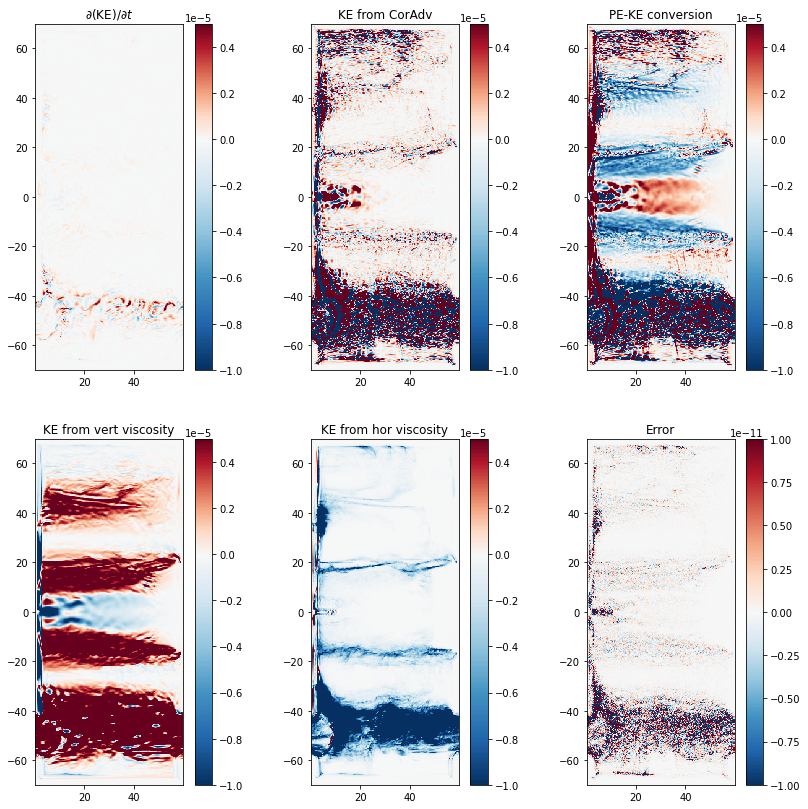

In [9]:
plt.figure(figsize=(14,14))


cmin=-1e-5; cmax=.5e-5;
plt.subplot(2,3,1)
plt.pcolormesh(xh,yh,KEterm1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial ($KE$)/\partial t$')
plt.colorbar()

plt.subplot(2,3,2)
plt.pcolormesh(xh,yh,KEterm2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from CorAdv')
plt.colorbar()

plt.subplot(2,3,3)
plt.pcolormesh(xh,yh,(KEterm3+KEterm4),norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'PE-KE conversion')
plt.colorbar()


plt.subplot(2,3,4)
plt.pcolormesh(xh,yh,KEterm5,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from vert viscosity')
plt.colorbar()

plt.subplot(2,3,5)
plt.pcolormesh(xh,yh,KEterm6,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from hor viscosity')
plt.colorbar()

plt.subplot(2,3,6)
plt.pcolormesh(xh,yh,E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-1e-11,vmax=1e-11)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'Error')

plt.colorbar()

Text(0.5, 1.0, 'Outside ACC, 1/4$^\\circ$')

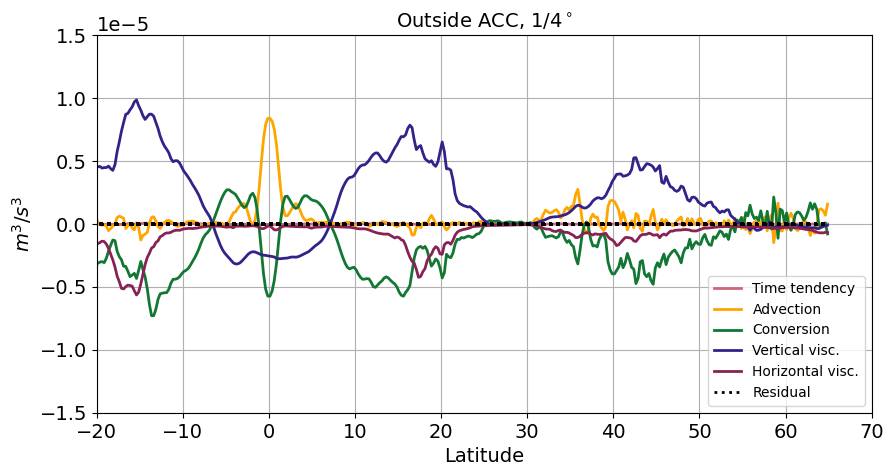

In [27]:
plt.rc('font', size=14)

plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_plot,KEterm1,'-',c='#CC6677',linewidth=2)
plt.plot(yh_plot,KEterm2,'-',c='#FFA500',linewidth=2)
plt.plot(yh_plot,(KEterm3+KEterm4),'-',c='#117733',linewidth=2)
plt.plot(yh_plot,(KEterm5),'-',c='#332288',linewidth=2)
plt.plot(yh_plot,(KEterm6),'-',c='#882255',linewidth=2)
plt.plot(yh_plot,E,':',c='k',linewidth=2)


plt.grid()

plt.legend(['Time tendency','Advection','Conversion','Vertical visc.','Horizontal visc.','Residual'],loc='lower right',fontsize=10)
#plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
plt.xlim(-20,70);# plt.xticks(fontsize=14); 
plt.ylim(-1.5e-5,1.5e-5); 
plt.yticks(fontsize=14)

#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('$m^3/s^3$',fontsize=14)
plt.title('Outside ACC, 1/4$^\circ$',fontsize=14)




Text(0.5, 1.0, 'ACC, 1/32$^\\circ$')

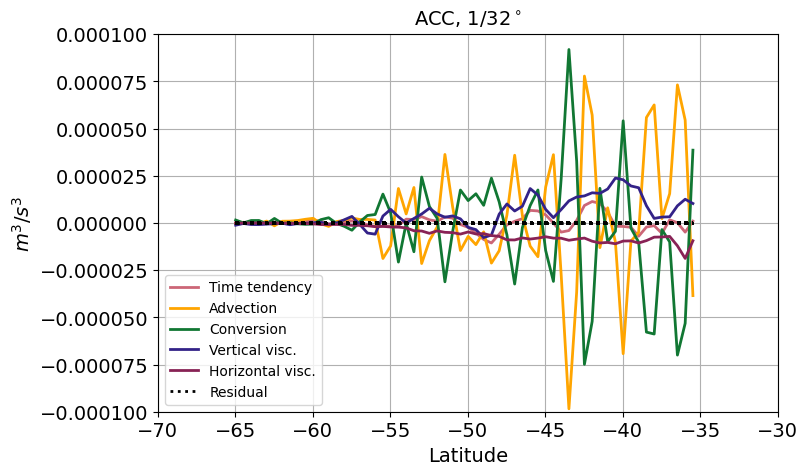

In [13]:
plt.rc('font', size=14)

plt.figure(figsize=(8, 5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_plot,KEterm1,'-',c='#CC6677',linewidth=2)
plt.plot(yh_plot,KEterm2,'-',c='#FFA500',linewidth=2)
plt.plot(yh_plot,(KEterm3+KEterm4),'-',c='#117733',linewidth=2)
plt.plot(yh_plot,(KEterm5),'-',c='#332288',linewidth=2)
plt.plot(yh_plot,(KEterm6),'-',c='#882255',linewidth=2)
plt.plot(yh_plot,E,':',c='k',linewidth=2)


plt.grid()

plt.legend(['Time tendency','Advection','Conversion','Vertical visc.','Horizontal visc.','Residual'],loc='lower left',fontsize=10)
#plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
plt.xlim(-70,-30);# plt.xticks(fontsize=14); 
plt.ylim(-1e-4,1e-4); 
plt.yticks(fontsize=14)

#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('$m^3/s^3$',fontsize=14)
plt.title('ACC, 1/32$^\circ$',fontsize=14)




In [28]:
np.array(KEterm1)

KeyboardInterrupt: 

(960,)

In [23]:
yh.shape

(2240,)

In [ ]:
#Picking out boxes to plot KE budgets for. Will plot area sum of weighted time-mean over 500 days after summing vertically
#Boxes with indexes shown for 1/4 degree:
#A: 40 to 50 lat (440:480); 15 to 45 lon (60:180)
#B: 20 to 40 lat (360:440); 15 to 45 lon (60:180)
#C: -60 to -30 lat (40:160); 15 to 45 lon (60:180)


In [105]:
#Isolating boxes

boxlat = np.arange(1760,1920)
boxlon = np.arange(240,720)

KEterm1 = np.nansum(np.array(av['dKE_dt'][:,:,boxlat,boxlon]),axis=1)
#assuming all of these are on the RHS of the KE equation
KEterm2 = np.nansum(np.array(av['KE_CorAdv'][:,:,boxlat,boxlon]),axis=1)
KEterm3 = np.nansum(np.array(av['PE_to_KE'][:,:,boxlat,boxlon]),axis=1)
KEterm4 = np.nansum(np.array(av['KE_BT'][:,:,boxlat,boxlon]),axis=1)
KEterm5 = np.nansum(np.array(av['KE_visc'][:,:,boxlat,boxlon]),axis=1)
KEterm6 = np.nansum(np.array(av['KE_horvisc'][:,:,boxlat,boxlon]),axis=1)


KEterm1 = np.nanmean(KEterm1,axis=0);
KEterm2 = np.nanmean(KEterm2,axis=0);
KEterm3 = np.nanmean(KEterm3,axis=0);
KEterm4 = np.nanmean(KEterm4,axis=0);
KEterm5 = np.nanmean(KEterm5,axis=0);
KEterm6 = np.nanmean(KEterm6,axis=0);

E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
area_box = area_t[np.ix_(boxlat,boxlon)]
print(KEterm1.shape,area_box.shape)

(160, 480) (160, 480)


In [106]:
boxterm1 = np.nansum(KEterm1*area_box/np.nansum(area_box))
boxterm2 = np.nansum(KEterm2*area_box/np.nansum(area_box))
boxterm34= np.nansum((KEterm3+KEterm4)*area_box/np.nansum(area_box))
boxterm5 = np.nansum(KEterm5*area_box/np.nansum(area_box))
boxterm6 = np.nansum(KEterm6*area_box/np.nansum(area_box))
boxerror = np.nansum(E*area_box/np.nansum(area_box))

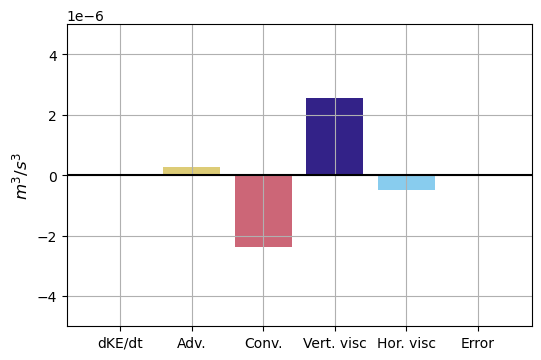

In [107]:
#plt.figure(figsize=(16, 6), dpi= 100, facecolor='w', edgecolor='k')


fig, ax1 = plt.subplots(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

# plt.grid()
# plt.legend(['Time tendency','Advection','Conversion','Vert. visc','Hor. visc','Residual'],loc='upper right',fontsize=12)
# plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
# plt.xlim(-20, 70)
# plt.ylim(-1e-5,1e-5);
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.xlabel('Latitude',fontsize=12)
plt.ylabel('$m^3/s^3$',fontsize=12)
# plt.title('1/4$^\circ$ KE budget terms',fontsize=14)




# create a dataset
height = [boxterm1, boxterm2, boxterm34, boxterm5, boxterm6, boxerror]
bars = ('dKE/dt', 'Adv.', 'Conv.', 'Vert. visc', 'Hor. visc', 'Error')
x_pos = np.arange(len(bars))

# Create bars with different colors
ax1.plot([-1,6],[0,0], 'k')
ax1.bar(x_pos, height, color = ['#117733','#ddcc77','#cc6677','#332288','#88ccee','k'])

ax1.plot([])
ax1.set_xlim([-0.75,5.75])
ax1.set_ylim([-5e-6,5e-6])

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.grid('on')
# Show graph
plt.show()